<a href="https://colab.research.google.com/github/Vennyx14/Finbert_SOTA/blob/main/FinBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup & Config**


In [1]:
!pip install -q transformers torch pandas scikit-learn tqdm

import random, os, math, time

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import warnings

import os
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    logging
)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.set_verbosity_warning()


In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/FinBERT_Crypto_Project"
os.makedirs(drive_path, exist_ok=True)

class Config:
    MODEL_NAME = "ProsusAI/finbert"

    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    EPOCHS = 8
    LR = 2e-5

    ACCUM_STEPS = 2

    WEIGHT_DECAY = 0.01
    WARMUP_RATIO = 0.1
    NUM_LABELS = 3
    OUTPUT_DIR = drive_path
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED = 42

print("Device:", Config.DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


# **2.Data Preparation**

##Normalize & Load dataset

In [3]:
def normalize_labels(series):
    """
    Normalize labels to:
    0 = negative, 1 = neutral, 2 = positive
    """
    # Case 1: string labels
    if series.dtype == object:
        s = series.astype(str).str.lower().str.strip()

        label_map = {
            "negative": 0,
            "neg": 0,
            "bearish": 0,

            "neutral": 1,
            "neu": 1,

            "positive": 2,
            "pos": 2,
            "bullish": 2
        }

        mapped = s.map(label_map)

        if mapped.isna().any():
            bad = s[mapped.isna()].unique()
            raise ValueError(f"Unknown label values: {bad}")

        return mapped.astype(int)

    # Case 2: numeric labels
    else:
        unique_vals = sorted(series.unique())

        if set(unique_vals) == {0, 1, 2}:
            return series.astype(int)

        if set(unique_vals) == {-1, 0, 1}:
            return series.map({-1: 0, 0: 1, 1: 2}).astype(int)

        raise ValueError(f"Unrecognized numeric labels: {unique_vals}")


In [4]:
def load_data(path):
  df = pd.read_csv(path)

  df.columns = [c.lower().strip() for c in df.columns]

  # find text col
  if "text" in df.columns:
    pass
  elif "sentence" in df.columns:
    df.rename(columns={"sentence": "text"}, inplace=True)

  # find label col
  if "label" in df.columns:
    pass
  elif "sentiment" in df.columns:
    df.rename(columns={"sentiment": "label"}, inplace=True)

  df = df.dropna(subset=["text", "label"])

  df["text"] = (
        df["text"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.strip()
    )

  df["label"] = normalize_labels(df["label"])
  df["label"] = df["label"].astype(int)

  return df

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# Dataset
class CryptoDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        txt = str(self.texts[idx])
        enc = self.tokenizer(
            txt,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_tensors=None
        )

        item = {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": int(self.labels[idx])
        }

        if "token_type_ids" in enc:
            item["token_type_ids"] = enc["token_type_ids"]
        return item

# Collate: dynamic padding + trả tensors
def collate_fn(batch):
    # batch: list of dicts with lists for ids/mask
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    to_pad = {"input_ids": input_ids, "attention_mask": attention_mask}

    if "token_type_ids" in batch[0]:
        to_pad["token_type_ids"] = [b["token_type_ids"] for b in batch]

    padded = tokenizer.pad(
    to_pad,
    padding=True,
    return_tensors="pt"
    )
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    padded["labels"] = labels
    return padded


##Test

In [5]:
df_finance = load_data("/data.csv")
print(f"Finance loaded: {len(df_finance)} rows")


# XỬ LÝ DỮ LIỆU CRYPTO
df_crypto = pd.read_csv("/cryptonews.csv")

def clean_sentiment_col(row):

    if isinstance(row, str) and "{" in row:
        try:
            data_dict = ast.literal_eval(row)
            return data_dict.get('class')
        except:
            return None
    return row

sent_col = 'sentiment' if 'sentiment' in df_crypto.columns else 'Sentiment'
df_crypto['label'] = df_crypto[sent_col].apply(clean_sentiment_col)

# normalize_labels
df_crypto['label'] = normalize_labels(df_crypto['label'])
df_crypto = df_crypto[['text', 'label']]

print(f"Crypto loaded: {len(df_crypto)} rows")


# Gộp & # Xáo trộn ngẫu nhiên
df = pd.concat([df_finance, df_crypto], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("-" * 30)
print(f"TỔNG DỮ LIỆU SAU GỘP: {len(df)}")
print(df['label'].value_counts())
print("-" * 30)
print(df.head())

Finance loaded: 5842 rows
Crypto loaded: 31037 rows
------------------------------
TỔNG DỮ LIỆU SAU GỘP: 36879
label
2    15816
1    13685
0     7378
Name: count, dtype: int64
------------------------------
                                                text  label
0  Web 3.0 and the metaverse are currently the ho...      2
1  After Binance said that it would cease trading...      1
2  Bitcoin traders ramp up bullish prognoses as B...      0
3  Honduras is not adopting bitcoin as legal tend...      2
4  Major global central banks, spanning Europe, N...      2


In [6]:

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=Config.SEED
)

train_dataset = CryptoDataset(
    train_texts,
    train_labels,
    tokenizer,
    Config.MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

batch = next(iter(train_loader))

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:", batch["labels"].shape)

# Tạo Dataset cho tập Validation
val_dataset = CryptoDataset(
    val_texts,
    val_labels,
    tokenizer,
    Config.MAX_LEN
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Số batch trong tập Train: {len(train_loader)}")
print(f"Số batch trong tập Val: {len(val_loader)}")


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([16, 52])
labels shape: torch.Size([16])
Số batch trong tập Train: 1844
Số batch trong tập Val: 461


# **3. Model Setup**

##Load FinBERT + Classification Head

In [7]:
def get_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS
    )

    model.to(Config.DEVICE)
    return model


model = get_model()

In [8]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##Optimizer

In [9]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
        "weight_decay": Config.WEIGHT_DECAY,
    },
    {
        "params": [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=Config.LR,
    eps=1e-8
)


##Warmup & Scheduler Setup

In [10]:
num_training_steps = int(len(train_loader) * Config.EPOCHS / Config.ACCUM_STEPS)
num_warmup_steps = int(Config.WARMUP_RATIO * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

##AMP-Mixed precision

In [11]:
scaler = torch.cuda.amp.GradScaler()

print(f"Total training steps: {num_training_steps}")
print("Model Setup Complete.")

Total training steps: 7376
Model Setup Complete.


# **4. Training Engine**


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits,
            targets,
            weight=self.weight,
            reduction="none"
        )
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [13]:
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# Helpers
def get_lr(optimizer):
    for g in optimizer.param_groups:
        return g['lr']

def save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, path):
    os.makedirs(path, exist_ok=True)
    # Save model + tokenizer + optimizer + scheduler states
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
    }, os.path.join(path, "training_state.pt"))
    # Saving model & tokenizer for inference
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

def load_checkpoint(path, model, optimizer=None, scheduler=None, device=None):
    ckpt = torch.load(os.path.join(path, "training_state.pt"), map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    if optimizer is not None and ckpt.get('optimizer_state_dict') is not None:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler is not None and ckpt.get('scheduler_state_dict') is not None:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    return ckpt.get('epoch', None)


def to_device_batch(batch, device):
    # Move all tensors in batch dict to device
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.to(device)
    return batch

def train_one_epoch(model,dataloader,optimizer,criterion,scheduler=None,epoch=0,
                    scaler=None,accumulation_steps=1,device=None,max_grad_norm=1.0):

    model.train()
    total_loss = 0.0
    step = 0

    optimizer.zero_grad()
    pbar = tqdm(dataloader, desc=f"Train E{epoch}")

    for i, batch in enumerate(pbar):
        step += 1

        # move batch to device
        batch = to_device_batch(batch, device)

        labels = batch["labels"]

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids", None)
            )
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss = loss / accumulation_steps

        # backward
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # update
        if (i + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            if scheduler is not None:
                scheduler.step()

            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        pbar.set_postfix(
            loss=f"{total_loss/step:.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.2e}"
        )

    return total_loss / step

# Evaluation function
def evaluate(model, dataloader, device=None):
    model.eval()
    preds = []
    trues = []
    probs_all = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Eval")
    with torch.no_grad():
        for i, batch in pbar:
            batch = to_device_batch(batch, device)
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            token_type_ids = batch.get('token_type_ids', None)
            labels = batch['labels']

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=-1)

            preds.extend(pred.detach().cpu().tolist())
            trues.extend(labels.detach().cpu().tolist())
            probs_all.extend(probs.detach().cpu().tolist())

    # Metrics
    weighted_f1 = f1_score(trues, preds, average='weighted')
    macro_f1 = f1_score(trues, preds, average='macro')
    report = classification_report(trues, preds, digits=4, output_dict=True)
    cm = confusion_matrix(trues, preds)
    return {
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
        'report': report,
        'confusion_matrix': cm,
        'preds': preds,
        'trues': trues,
        'probs': probs_all
    }


In [14]:
train_losses = []

def train_loop(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=Config.EPOCHS,
    accumulation_steps=Config.ACCUM_STEPS,
    class_weights=None,
    patience=3,
    device=Config.DEVICE,
    output_dir=Config.OUTPUT_DIR,
    max_grad_norm=1.0,
    use_amp=True
):
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None


    if class_weights is not None:
        criterion = FocalLoss(
            gamma=2.0,
            weight=class_weights.to(device)
        )
    else:
        criterion = torch.nn.CrossEntropyLoss()

    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            epoch=epoch,
            scaler=scaler,
            accumulation_steps=accumulation_steps,
            device=device,
            max_grad_norm=max_grad_norm
        )
        train_losses.append(train_loss)

        val_metrics = evaluate(model, val_loader, device=device)
        val_macro_f1 = val_metrics["macro_f1"]

        print(f"\nEpoch {epoch}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Val macro F1: {val_macro_f1:.4f}")

        if val_macro_f1 > best_val_f1:
            best_val_f1 = val_macro_f1
            best_epoch = epoch
            epochs_no_improve = 0

            ckpt_path = os.path.join(
                output_dir,
                f"best_model_epoch{epoch}_macroF1{val_macro_f1:.4f}"
            )
            save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, ckpt_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_val_f1, train_losses


In [15]:
# ===== Compute class weights =====
train_labels_array = np.array(train_labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_array),
    y=train_labels_array
)

class_weights_tensor = torch.tensor(
    class_weights, dtype=torch.float
).to(Config.DEVICE)

print(f"Class Weights: {class_weights_tensor}")

# ===== Train =====
print(f"\n TRAINING FOR {Config.EPOCHS} EPOCHS")

best_f1_score, train_losses = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=Config.EPOCHS,
    accumulation_steps=Config.ACCUM_STEPS,
    class_weights=class_weights_tensor,
    patience=3,
    device=Config.DEVICE,
    output_dir=Config.OUTPUT_DIR
)

print(f"\n FINAL RESULT — Best Macro F1: {best_f1_score:.4f}")

Class Weights: tensor([1.6663, 0.8983, 0.7772], device='cuda:0')

 TRAINING FOR 8 EPOCHS


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E1:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/461 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 1
Train loss: 0.5682
Val macro F1: 0.7503


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E2:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/461 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 2
Train loss: 0.1548
Val macro F1: 0.8743


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E3:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 3
Train loss: 0.0736
Val macro F1: 0.9017


Train E4:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 4
Train loss: 0.0458
Val macro F1: 0.9090


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E5:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 5
Train loss: 0.0281
Val macro F1: 0.9127


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E6:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/461 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 6
Train loss: 0.0180
Val macro F1: 0.9122


Train E7:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 7
Train loss: 0.0133
Val macro F1: 0.9151


Train E8:   0%|          | 0/1844 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 8
Train loss: 0.0110
Val macro F1: 0.9153

 FINAL RESULT — Best Macro F1: 0.9153


In [23]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:

            input_ids = batch["input_ids"].to(Config.DEVICE)
            attention_mask = batch["attention_mask"].to(Config.DEVICE)
            labels = batch["labels"].to(Config.DEVICE)

            token_type_ids = batch.get("token_type_ids")
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(Config.DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu().numpy()
    real_values = torch.stack(real_values).cpu().numpy()
    return predictions, real_values

y_pred, y_test = get_predictions(model, val_loader)

class_names = ['Negative', 'Neutral', 'Positive']

print("FINAL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
print("="*50)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.8371    0.9085    0.8713      1476
     Neutral     0.9516    0.9057    0.9281      2737
    Positive     0.9454    0.9472    0.9463      3163

    accuracy                         0.9241      7376
   macro avg     0.9114    0.9205    0.9153      7376
weighted avg     0.9260    0.9241    0.9246      7376



# **5. Evaluation & Analysis**

In [17]:
model.eval()

all_preds = []
all_trues = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(Config.DEVICE) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_trues = np.array(all_trues)
all_probs = np.array(all_probs)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


              precision    recall  f1-score   support

    negative     0.8371    0.9085    0.8713      1476
     neutral     0.9516    0.9057    0.9281      2737
    positive     0.9454    0.9472    0.9463      3163

    accuracy                         0.9241      7376
   macro avg     0.9114    0.9205    0.9153      7376
weighted avg     0.9260    0.9241    0.9246      7376



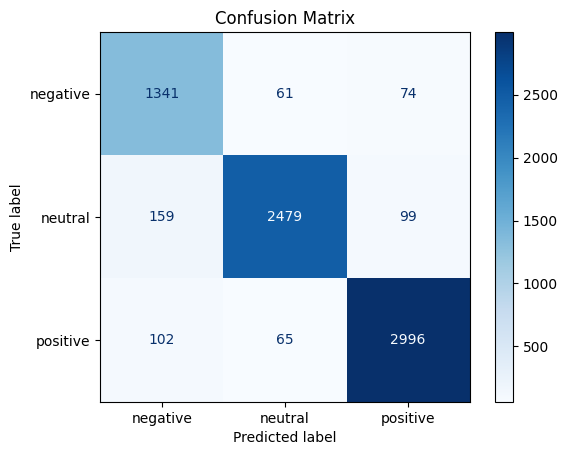

In [18]:
print(classification_report(
    all_trues,
    all_preds,
    target_names=["negative", "neutral", "positive"],
    digits=4
))

cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [19]:
wrong_idx = np.where(all_preds != all_trues)[0]

# Sắp xếp theo độ tự tin của dự đoán sai (max prob)
confidence = all_probs[wrong_idx].max(axis=1)
top_wrong = wrong_idx[np.argsort(-confidence)][:10]

for i in top_wrong:
    print("TEXT:")
    print(val_texts.iloc[i])
    print(f"TRUE: {all_trues[i]} | PRED: {all_preds[i]} | PROBS: {all_probs[i]}")
    print("-" * 80)

TEXT:
Animoca Brands has disclosed that it is \x9cfinancially strong\x9d to continue operations.
TRUE: 1 | PRED: 2 | PROBS: [0.00242466 0.00623336 0.991342  ]
--------------------------------------------------------------------------------
TEXT:
Altona stated that the private company of Altona chairman Kevin Maloney , Tulla Resources , would take up its entitlement in full .
TRUE: 1 | PRED: 2 | PROBS: [0.00361831 0.00641971 0.9899621 ]
--------------------------------------------------------------------------------
TEXT:
Bitcoin started March on a positive note, but historically the month has recorded mediocre gains, which could be an early warning sign for crypto investors.
TRUE: 0 | PRED: 2 | PROBS: [0.00618957 0.00458937 0.98922104]
--------------------------------------------------------------------------------
TEXT:
There’s no denying that cryptocurrencies are taking over the global financial industry. Millions of people use them on a daily basis and the field has grown tremendous

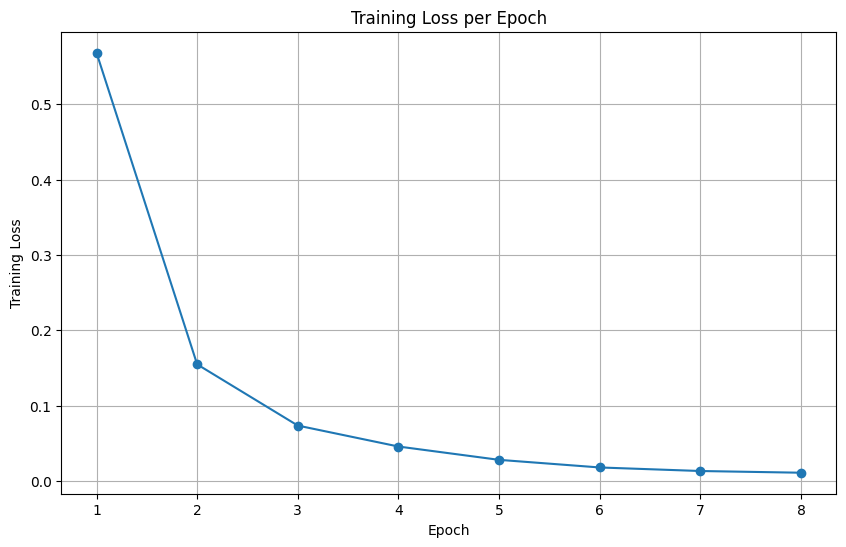

In [20]:
# VẼ BIỂU ĐỒ LOSS
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.savefig('loss_table.png', dpi=300)
plt.show()





In [21]:
from google.colab import files

In [22]:
files.download('loss_table.png')
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>